In [1]:
import numpy as np
import matplotlib.pyplot as plt

import lightkurve as lk
from astropy.units import cds
from astropy import units as u
import seaborn as sns
import mystyle as ms

import corner
import pystan
import pandas as pd
import pickle
import glob
from astropy.io import ascii
import os

import pymc3 as pm
import arviz
import warnings
warnings.filterwarnings('ignore')

In [2]:
target = 3632418
cop = pd.read_csv('../../data/copper.csv',index_col=0)
cop = cop[cop.l == 0].loc[cop.KIC == str(target)]

In [3]:
g0_ = cop.Width.values
g0_e = cop.E_Width.values
f0_true = cop.Freq.values
f0_e = cop.e_Freq.values
f0_ = np.linspace(0.0, 1.0, len(f0_true))[:, None]

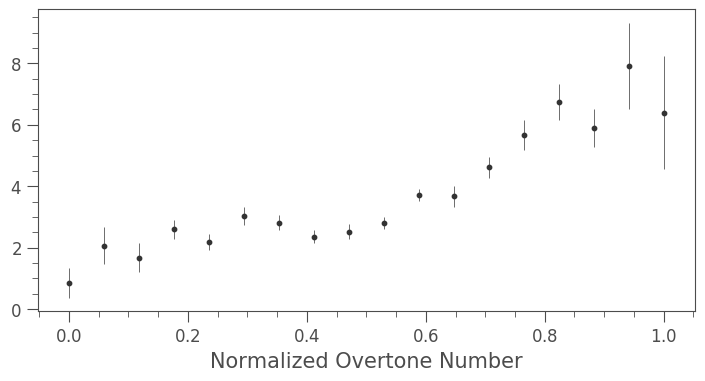

In [32]:
with plt.style.context(ms.ms):
    plt.errorbar(f0_, g0_, yerr=g0_e, fmt='|')
    plt.scatter(f0_, g0_, s=10)
    plt.xlabel('Normalized Overtone Number')

We're going to treat the frequencies as evently spaced by $\Delta\nu$. Of course in practice this isn't the case, due to curvature in the distribution of modes and noise due to glitches. However in the limit that the length scale of the GP, $L$, is much larger than these fluctuations we don't need to include them in the GP.

In [26]:
pm_model = pm.Model()
with pm_model:
    m0 = pm.Normal('gradient0', mu=0, sigma=10)
    c0 = pm.Normal('intercept0', mu=0, sigma=10)
    sigma0 = pm.TruncatedNormal('sigma0', mu=1.0, sigma=10, lower=0.)
    ls = pm.TruncatedNormal('ls', mu=0.3, sigma=10, lower=0.)
    
    mu0 = pm.gp.mean.Linear(coeffs=m0, intercept=c0)
    cov0 = sigma0 * pm.gp.cov.ExpQuad(1, ls=ls)
    
    gp0 = pm.gp.Latent(cov_func= cov0, mean_func=mu0)
    
    g0 = gp0.prior('g0', X=f0_)
    
    like = pm.Normal('like', mu=g0, sigma=g0_e, observed=g0_)

In [27]:
with pm_model:
    trace = pm.sample(chains=4)

INFO:pymc3:Auto-assigning NUTS sampler...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:NUTS: [g0_rotated_, ls, sigma0, intercept0, gradient0]
Sampling 4 chains: 100%|██████████| 4000/4000 [01:20<00:00, 49.95draws/s]
ERROR:pymc3:There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
INFO:pymc3:The number of effective samples is smaller than 25% for some parameters.


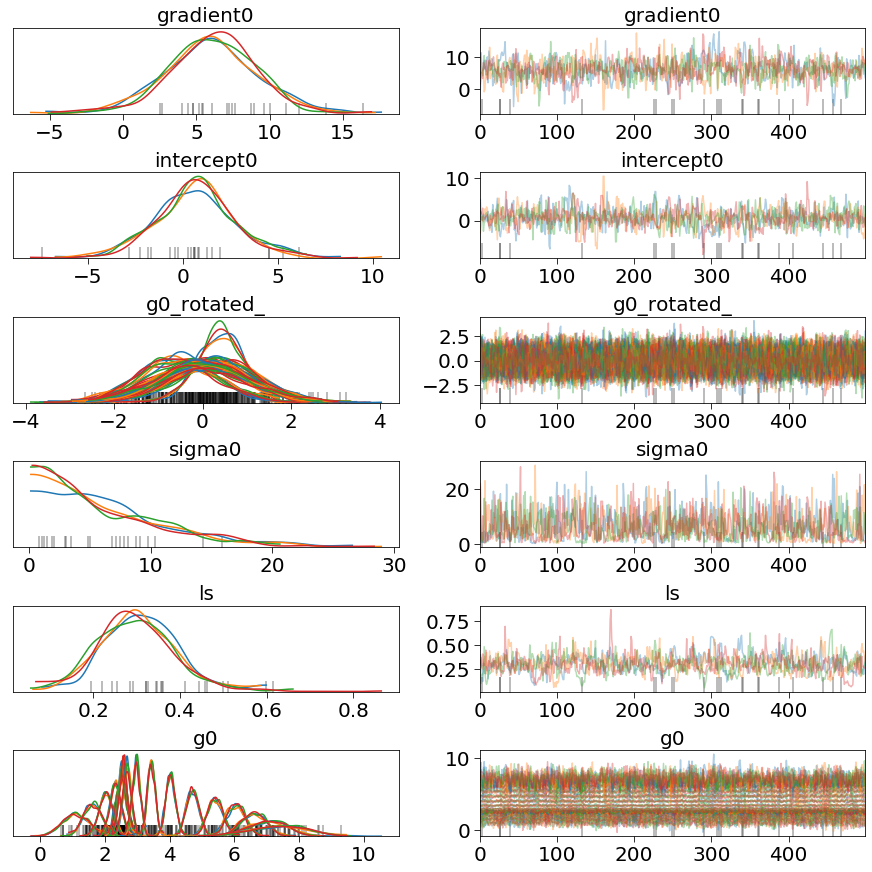

In [28]:
pm.traceplot(trace)
plt.show()

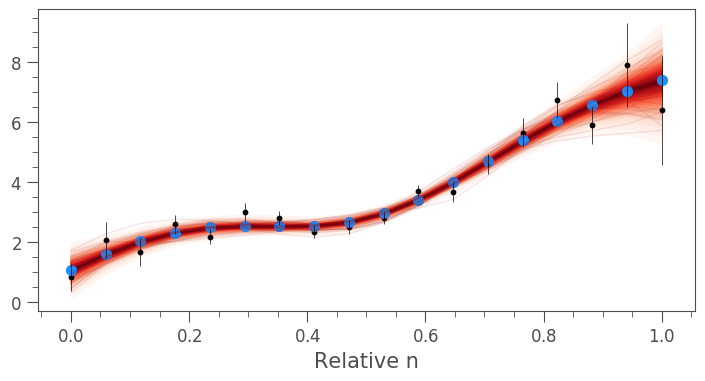

In [29]:
from pymc3.gp.util import plot_gp_dist

with plt.style.context(ms.ms):
    fig, ax = plt.subplots()
    
    plot_gp_dist(ax, trace['g0'], f0_)
    
    plt.errorbar(f0_, g0_, yerr=g0_e, fmt='|',c="k", label='Truth')
    plt.scatter(f0_, g0_, s=10,c="k")
    
    plt.scatter(f0_, np.median(trace['g0'],axis=0), s=50, c='dodgerblue')
    plt.xlabel('Relative n')
    plt.show()

### Lets try it real quick anyway...

Actually I'm not sure this is even possible in PyMC3...

In [31]:
pm_model = pm.Model()
with pm_model:
    f0 = pm.Normal('f0', mu=f0_true, sigma=f0_e, shape=len(f0_true))
    f0in = pm.Deterministic('f0in', f0[:,None])
    
    
    m0 = pm.Normal('gradient0', mu=0, sigma=10)
    c0 = pm.Normal('intercept0', mu=0, sigma=10)
    sigma0 = pm.TruncatedNormal('sigma0', mu=1.0, sigma=10, lower=0.)
    ls = pm.TruncatedNormal('ls', mu=0.3, sigma=10, lower=0.)
    
    mu0 = pm.gp.mean.Linear(coeffs=m0, intercept=c0)
    cov0 = sigma0 * pm.gp.cov.ExpQuad(1, ls=ls)
    
    gp0 = pm.gp.Latent(cov_func= cov0, mean_func=mu0)
    
    g0 = gp0.prior('g0', X=f0in)
    
    like = pm.Normal('like', mu=g0, sigma=g0_e, observed=g0_)

TypeError: Cannot infer 'shape', provide as an argument

In [ ]:
with pm_model:
    pm.trace(chains=4)